# Kidney 3 EDA

In [1]:
import os
from surface_dice import SurfaceDiceMetric
import pandas as pd
from PIL import Image
import torch
from torchvision.transforms import ToTensor
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
input_dir = "/kaggle/input/blood-vessel-segmentation/"
train_dir = input_dir + "train/"
dense_dir = train_dir + "kidney_3_dense/"
sparse_dir = train_dir + "kidney_3_sparse/"

dense_msks = sorted(os.listdir(dense_dir + "labels"))
sparse_msks = sorted(os.listdir(sparse_dir + "labels"))

print("Number of dense masks:", len(dense_msks))
print("Number of sparse masks:", len(sparse_msks))

Number of dense masks: 501
Number of sparse masks: 1035


In [3]:
print(dense_msks[:10])
print(sparse_msks[:10])

['0496.tif', '0497.tif', '0498.tif', '0499.tif', '0500.tif', '0501.tif', '0502.tif', '0503.tif', '0504.tif', '0505.tif']
['0000.tif', '0001.tif', '0002.tif', '0003.tif', '0004.tif', '0005.tif', '0006.tif', '0007.tif', '0008.tif', '0009.tif']


### ¿Are the images with dense masks a subset of the images with sparse masks?

Yes.

In [4]:
sorted(list(set(dense_msks) & set(sparse_msks))) == dense_msks


True

Image ID: 737


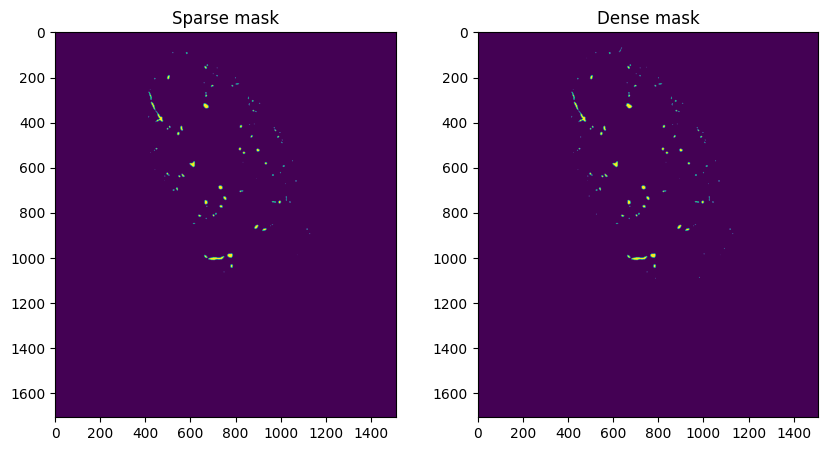

In [5]:
idx = torch.randint(len(dense_msks), (1,)).item()


img1 = np.array(Image.open(sparse_dir + "labels/" + dense_msks[idx]))
img2 = np.array(Image.open(dense_dir + "labels/" + dense_msks[idx]))

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

print(f"Image ID: {idx + 496}")
axs[0].imshow(img1)
axs[0].set_title("Sparse mask")
axs[1].imshow(img2)
axs[1].set_title("Dense mask")
plt.show()


### Comparison using Surface Dice metric

In [6]:
class ComparisonDataset(torch.utils.data.Dataset):
    def __init__(self, dir1, dir2, ids):
        self.dir1 = dir1
        self.dir2 = dir2
        self.ids = ids

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        img1_path = self.dir1 + self.ids[idx]
        img2_path = self.dir2 + self.ids[idx]
        
        img1 = Image.open(img1_path)
        img2 = Image.open(img2_path)

        img1 = torch.as_tensor(np.array(img1) / 255, dtype=torch.uint8)
        img2 = torch.as_tensor(np.array(img2) / 255, dtype=torch.uint8)

        return img1, img2

In [7]:
ds = ComparisonDataset(sparse_dir + "labels/", dense_dir + "labels/", dense_msks)
dl = torch.utils.data.DataLoader(ds, batch_size=16, shuffle=False, num_workers=os.cpu_count())

In [8]:
metric = SurfaceDiceMetric(len(dl), device)

for imgs1, imgs2 in tqdm(dl):
    imgs1, imgs2 = imgs1.to(device), imgs2.to(device)
    metric.process_batch(imgs1, imgs2)

dice = metric.compute()

dice

  0%|          | 0/32 [00:00<?, ?it/s]

100%|██████████| 32/32 [01:46<00:00,  3.32s/it]


0.9814293384552002